# Expe 1, noise tagging condition, individual analysis of participant A2

In [1]:
data_path = '/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1'
trial_info_file = '/data/A2/converted/trialinfo_matrix_A2_cleanedtrials.mat'
data_file = '/data/A2/Experimental/data.mat'
epoch_file = '/epochs_from_matrix/epochs_2.fif'

# Posterior electrodes
relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz'] 
# Best electrodes in frequency tagging condition
freqtag_electrodes = ['Iz', 'PO3', 'POz', 'P3', 'P7', 'P5']

# Dic to index trial_info matrix
info_colnames = {'0':0 ,'1':1 ,'RT':2,'PTB_check_RT_error':3, 'answer':4,'stimuli_target_interval':5,\
                      'base_delay':6, 'flicker_sides':7, 'cued_side':8, 'orients_L':9, 'orients_r':10,\
                      'ignore_column':11, 'target_angle':12, 'tagging_type':13, 'trial_number':14}

In [2]:
import scipy.io as sio
import scipy
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import mne
from mne.time_frequency import EpochsTFRArray
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from noise_tagging_funs import normalize_per_trial, generate_noise_periods, cross_cor_nois, bin_to_dataframe

In [3]:
# Load trial info
f = sio.loadmat(f'{data_path}{trial_info_file}')
trial_info = f['all_info']

# Get target binary (i.e if a shift happened)
f = sio.loadmat(f'{data_path}{data_file}')
target_binary =f['data']['targets_binary'][0][0]
# Remove practice trials
target_binary = target_binary[1:,:]
# Collapse to trial indexes
original_shape = target_binary.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
target_binary = np.reshape(target_binary, new_shape)
target_binary = pd.DataFrame({'trial_number':np.arange(target_binary.shape[0]), 'target_binary':target_binary})

# Create pd df to pass to mne metadata
pd_info = pd.DataFrame(trial_info, columns=info_colnames.keys())
pd_info['trial_number']= pd_info['trial_number'].astype(int) - 1
pd_info = pd.merge(pd_info, target_binary, on = 'trial_number')

# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epochs.metadata = pd_info


Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/epochs_from_matrix/epochs_2.fif ...


/tmp/ipykernel_9728/448556551.py:22: RuntimeWarning: This filename (/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/epochs_from_matrix/epochs_2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f'{data_path}{epoch_file}')


    Found the data of interest:
        t =   -1000.00 ...    2299.32 ms
        0 CTF compensation matrices available
Not setting metadata
467 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 16 columns


In [4]:
# Keep only posterior electrodes
epochs.pick_channels(relevant_electrodes)

# Keep only trials without targets
epochs = epochs['target_binary == 0']

# Resample to the projectors sampling rate
epochs.resample(480)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Number of events,380
Events,1: 380
Time range,-1.000 – 2.298 s
Baseline,off


# Adding 10% of Noise

In [5]:
epochs_noistag = epochs['tagging_type==1'].copy()
# bandpass (60-80Hz) EEG data 
# epochs_noistag.filter(l_freq=60, h_freq = 80, verbose=True)
# Access noise tags
f = sio.loadmat(f'{data_path}{data_file}')
noise_stims = f['data']['noise_stims'][0][0] # block x trial x sequences (L or R tag) x timepoints
# Filter out practice trials
noise_stims = noise_stims[1:,:,:,:]

In [7]:
# Collapse to trial indexes
original_shape = noise_stims.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
noise_stims_tr = np.reshape(noise_stims, new_shape)

In [9]:
sfreq = 480
noise_stims_tr_fitlered = mne.filter.filter_data(noise_stims_tr, sfreq, None, 100)
tmin = epochs_noistag.tmin
tmax = epochs_noistag.tmax
#Up to when should the tag be present
tmax_noise = 1
# Inject to each EEG epoch its matching cued tag
buffer_arr = epochs_noistag.get_data()
# z-score EEG by electrode and trial
buffer_arr = (buffer_arr - np.mean(buffer_arr, axis=2, keepdims=True))/np.std(buffer_arr, axis=2, keepdims=True)
# Reverse the EEG to ensure no real crosscorrelation
buffer_arr = buffer_arr[:,:,::-1]

# After which sample from cue onset should the noise be in the data
for idx, trial in enumerate(epochs_noistag.metadata['trial_number']):
    # Delay is the delay between stimulation and translation in brain, here 100ms
    delay = int(.*sfreq)
    # Offset is the moment where the noise is injected
    offset = int(np.random.normal(.1, .020)*sfreq)
    # Retrieve which tag was cued
    cued_side = int(epochs_noistag.metadata[epochs_noistag.metadata.trial_number == trial]['cued_side'])
    # Inject the tag displayed from cue onset to 800 ms after
    injected_tag = noise_stims_tr_fitlered[trial, cued_side, \
        :int(tmax_noise*sfreq)+1]
    # z-score tag
    injected_tag = (injected_tag - np.mean(injected_tag))/np.std(injected_tag)
    # Offset the moment of crosscorrelation but preserve phase
    injected_tag[:offset] = 0
    # Relative magnitude of the tag in the EEG
    injected_tag *= 0.111111#0.01010101
    # Add the tag from cue onset + time delay (offset)
    buffer_arr[idx,:,int(np.abs(epochs_noistag.tmin)*sfreq)+delay:int(np.abs(epochs_noistag.tmin)*sfreq+delay)+len(injected_tag)] += injected_tag
epochs_noistag._data = buffer_arr


Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 65 samples (0.135 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.5s
/tmp/ipykernel_9728/2556384809.py:8: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  buffer_arr = epochs_noistag.get_data()
/tmp/ipykernel_9728/2556384809.py:21: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cued_side = int(epochs_noistag.metadata[epochs_noistag.metadata.trial_number == trial]['cued_side'])


## 1. Cross-correlation of the cued and uncued tags (tag duration from 0 to 1s)

The EEG from -1 to 2s is correlated with the tags from 0 to 1s (positive time lag up to 1000ms). 
Only trials without targets are included. 
The EEG is correlated with each tag.
The electrodes used are the best from the frequency tagging condition.

Text(0, 0.5, 'Cor EEG/tag')

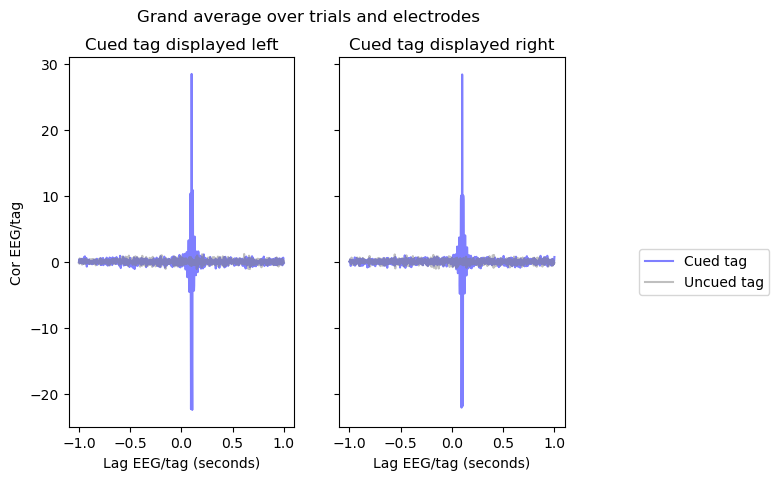

In [10]:
sfreq = 480 # EEG and tag 
tmin_eeg, tmax_eeg = -1, 2
tmin_noise, tmax_noise = 0, 1

cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = \
    cross_cor_nois(epochs_fun = epochs_noistag['target_binary == 0'], noise=noise_stims_tr, \
    display_side_cued_tag = 'right', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = \
    cross_cor_nois(epochs_noistag['target_binary == 0'], noise_stims_tr, 'left', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])


# Plot
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].plot(times,cor_with_cued_for_cuedL.mean(axis=(0,1)).T, color='blue', alpha=.5)
ax[0].plot(times,cor_with_uncued_for_cuedL.mean(axis=(0,1)).T, color='grey', alpha=.5)
ax[1].plot(times,cor_with_cued_for_cuedR.mean(axis=(0,1)).T, color='blue', label='Cued tag', alpha=.5)
ax[1].plot(times,cor_with_uncued_for_cuedR.mean(axis=(0,1)).T, color='grey', label='Uncued tag', alpha=.5)


ax[0].set_title('Cued tag displayed left');
ax[1].set_title('Cued tag displayed right');
plt.suptitle('Grand average over trials and electrodes');

ax[1].legend(bbox_to_anchor = (1.3,0.5))
ax[0].set_xlabel('Lag EEG/tag (seconds)')
ax[1].set_xlabel('Lag EEG/tag (seconds)')
ax[0].set_ylabel('Cor EEG/tag')

### 1.1 Comparing max cross-correlation pre vs post cue

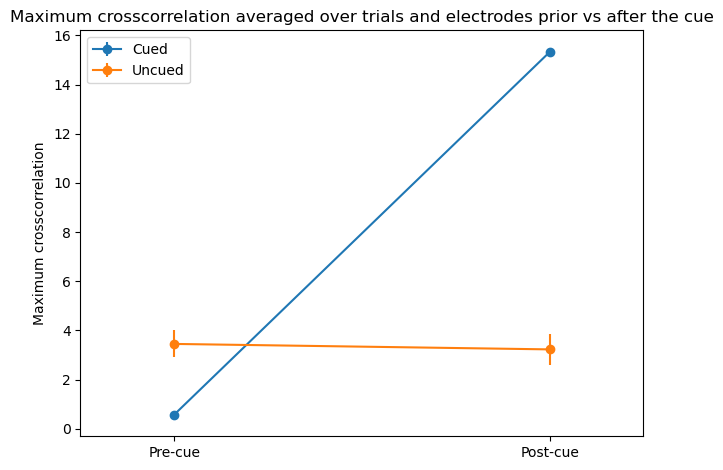

In [14]:
cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])


max_precue_cued = normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,:int(times.max()*sfreq)].max(axis=-1)
max_postcue_cued = normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,-int(times.max()*sfreq):].max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_cued), np.mean(max_postcue_cued)],
                yerr=[np.std(max_precue_cued), np.std(max_postcue_cued)], fmt='o-', label='Cued')
max_precue_uncued = normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,:int(times.max()*sfreq)].max(axis=-1)
max_postcue_uncued = normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,-int(times.max()*sfreq):].max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_uncued), np.mean(max_postcue_uncued)],
                yerr=[np.std(max_precue_uncued), np.std(max_postcue_uncued)], fmt='o-', label='Uncued')
                        
plt.xticks([0,1],['Pre-cue', 'Post-cue'])
plt.title('Maximum crosscorrelation averaged over trials and electrodes prior vs after the cue')
plt.legend()
plt.ylabel('Maximum crosscorrelation')
plt.xlim(-.25, 1.25)
plt.tight_layout()

In [15]:
# # Export for group analysis
# crosscor_prepost = {}
# crosscor_prepost['cued_pre'] = normalize_per_trial(cor_with_cued.mean(axis=0))[:,:cor_with_cued.shape[-1]//2+1].max(axis=-1)
# crosscor_prepost['cued_post'] = normalize_per_trial(cor_with_cued.mean(axis=0))[:,cor_with_cued.shape[-1]//2:].max(axis=-1)
# crosscor_prepost['uncued_pre'] = normalize_per_trial(cor_with_uncued.mean(axis=0))[:,:cor_with_uncued.shape[-1]//2+1].max(axis=-1)
# crosscor_prepost['uncued_post'] = normalize_per_trial(cor_with_uncued.mean(axis=0))[:,cor_with_uncued.shape[-1]//2:].max(axis=-1)
# crosscor_prepost['uncued_post'] 
# crosscor_prepost_df = pd.DataFrame(crosscor_prepost)
# crosscor_prepost_df = crosscor_prepost_df.melt()
# crosscor_prepost_df[['cued', 'prepost']] = crosscor_prepost_df['variable'].str.split('_', expand=True)
# crosscor_prepost_df = crosscor_prepost_df.drop('variable', axis=1)
# crosscor_prepost_df.to_csv('files/A2_crosscor_prepost.csv',index=False)

### 3.2 Timing of the crosscorrelation with each of the tags (cueing effect)

In [16]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
lag = .1

# Define period of noise to analyze
start = 0
duration = .4
step = .1
end = tmax_eeg-lag
# Create a list of tag segments of duration 400ms with a step of 100ms
noise_periods = generate_noise_periods(start, end, duration, step)[::-1]

# EEG segments studied
n_bins = 20
time_bins = np.linspace(start, tmax_eeg-duration, n_bins+1)*sfreq

max_values_per_bin_cued = np.zeros((len(noise_periods), n_bins))
max_values_per_bin_uncued = np.zeros((len(noise_periods), n_bins))

for j, period in enumerate(noise_periods):
    tmin_noise, tmax_noise = period
    
    cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = \
        cross_cor_nois(epochs_fun = epochs_noistag, noise=noise_stims_tr, \
        display_side_cued_tag = 'right',\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = \
        cross_cor_nois(epochs_noistag, noise_stims_tr, 'left', \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
    uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])

    for i in range(n_bins):
        start_idx = int(time_bins[i])
        end_idx = int(time_bins[i + 1])
        max_values_per_bin_cued[j, i] = np.mean(normalize_per_trial(cued.mean(axis=0)), axis=0)[start_idx:end_idx].max()
        max_values_per_bin_uncued[j, i] = np.mean(normalize_per_trial(uncued.mean(axis=0)), axis=0)[start_idx:end_idx].max()
    


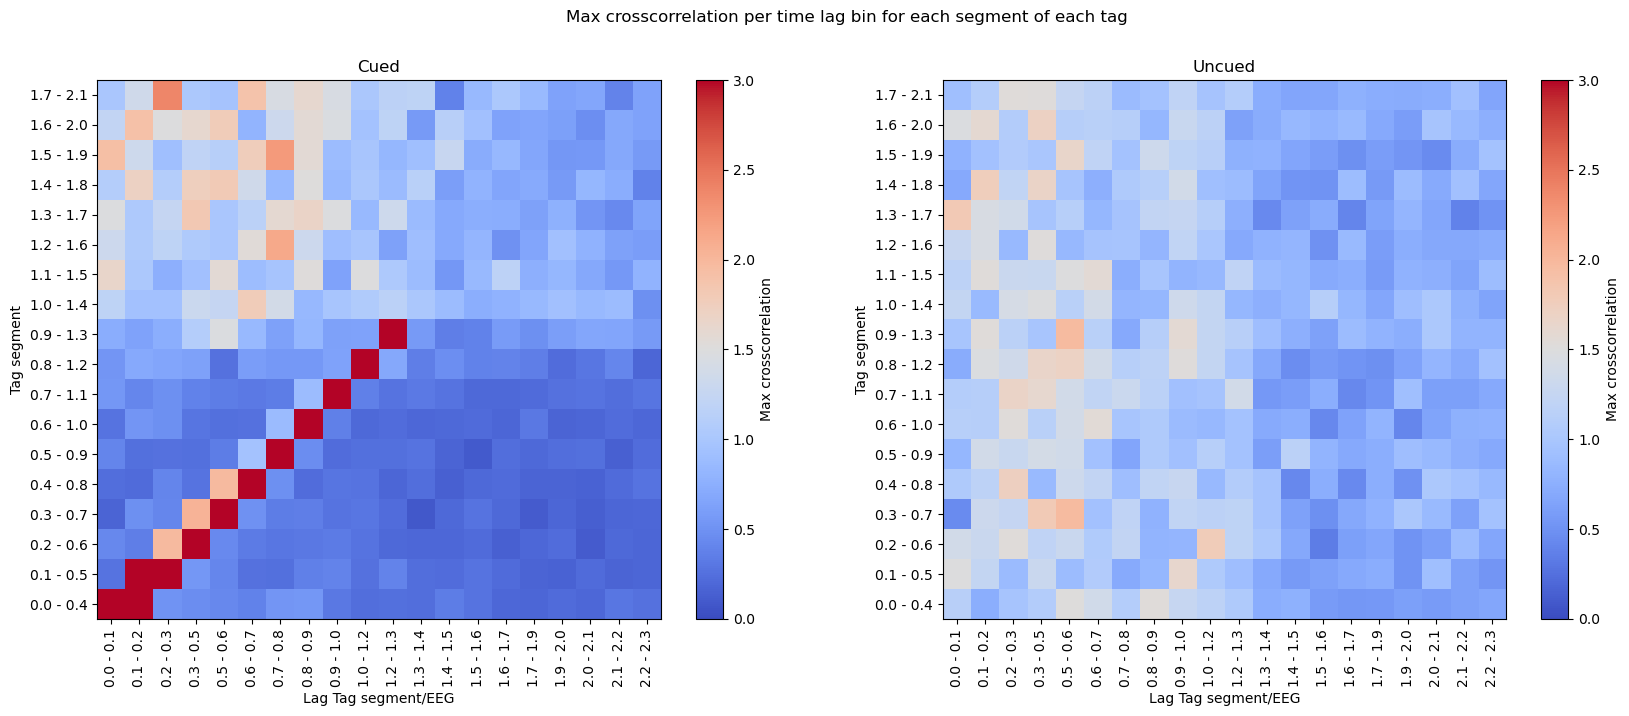

In [17]:
fig, ax = plt.subplots(1,2, figsize=(20,7), sharey=False)

cax = ax[0].imshow(max_values_per_bin_cued, aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=3)
cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation')
cax = ax[1].imshow(max_values_per_bin_uncued, aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=3)
cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation')

ax[0].set_xlabel('Lag Tag segment/EEG')
ax[0].set_ylabel('Tag segment')
ax[1].set_xlabel('Lag Tag segment/EEG')
ax[1].set_ylabel('Tag segment')
plt.suptitle('Max crosscorrelation per time lag bin for each segment of each tag')

bin_times = np.linspace(start, end, n_bins)
diff_bins = np.diff(bin_times)[0]

for axi in ax:
    axi.set_xticks(np.arange(n_bins))
    axi.set_xticklabels([f'{bt:.1f} - {bt+diff_bins:.1f}' for bt in bin_times], rotation=90)
    axi.set_yticks(np.arange(len(noise_periods)))
    axi.set_yticklabels([f'{i[0]:.1f} - {i[1]:.1f}' for i in noise_periods])


ax[0].set_title('Cued')
ax[1].set_title('Uncued')
plt.show()

### 1.2 Comparing max cross-correlation on displayed trial vs others

In [18]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
tmin_noise, tmax_noise = 0, 2

# First for left cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 0'].selection]
# (cued, uncued), trial, elec, time
trial_crosscorr_matL = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'left', electrodes=freqtag_electrodes, \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matL[0, trial_idx, :, :, :] = cor_with_cued_for_cuedL[:, :, :]
    trial_crosscorr_matL[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedL[:, :, :]

# For right cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 1'].selection]
trial_crosscorr_matR = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[ trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'right', electrodes=freqtag_electrodes,  \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matR[0, trial_idx, :, :, :] = cor_with_cued_for_cuedR[:, :, :]
    trial_crosscorr_matR[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedR[:, :, :]

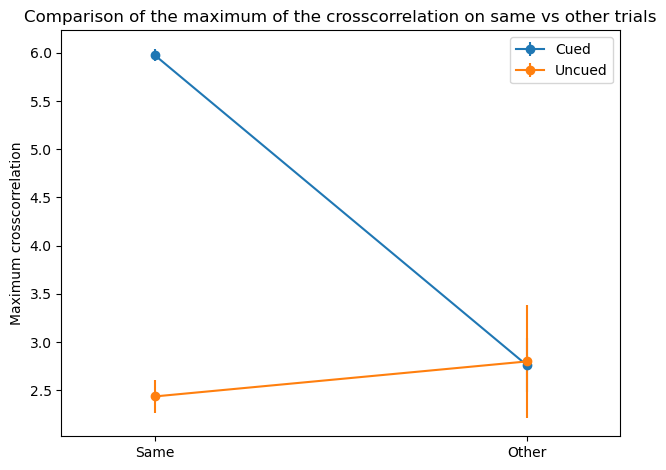

In [19]:
same_cued, same_uncued = [], []
other_cued, other_uncued = [], []

num_trials = trial_crosscorr_matL[0].shape[0]
for trial in range(num_trials):
    # Pick the same trial by taking the diagonal
    same_cued.append(trial_crosscorr_matL[0][trial, trial])
    same_uncued.append(trial_crosscorr_matL[1][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued.append(trial_crosscorr_matL[0][trial, sampled_index])
    other_uncued.append(trial_crosscorr_matL[1][trial, sampled_index])
    
num_trials = trial_crosscorr_matR[0].shape[0]
for trial in range(num_trials):
    same_cued.append(trial_crosscorr_matR[0][trial, trial])
    same_uncued.append(trial_crosscorr_matR[1][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued.append(trial_crosscorr_matR[0][trial, sampled_index])
    other_uncued.append(trial_crosscorr_matR[1][trial, sampled_index])

plt.errorbar(x=[0,1], y=[normalize_per_trial(np.array(same_cued).mean(axis=(0))).max(axis=-1).mean(), normalize_per_trial(np.array(other_cued).mean(axis=(0))).max(axis=-1).mean()],
                yerr=[normalize_per_trial(np.array(same_cued).mean(axis=(0))).max(axis=-1).std(), normalize_per_trial(np.array(other_cued).mean(axis=(0))).max(axis=-1).std()], fmt='o-', label='Cued')
plt.errorbar(x=[0,1], y=[normalize_per_trial(np.array(same_uncued).mean(axis=(0))).max(axis=-1).mean(), normalize_per_trial(np.array(other_uncued).mean(axis=(0))).max(axis=-1).mean()],
                yerr=[normalize_per_trial(np.array(same_uncued).mean(axis=(0))).max(axis=-1).std(), normalize_per_trial(np.array(other_uncued).mean(axis=(0))).max(axis=-1).std()], fmt='o-', label='Uncued')
plt.xticks([0,1],['Same', 'Other'])
plt.title('Comparison of the maximum of the crosscorrelation on same vs other trials')
plt.legend()
plt.ylabel('Maximum crosscorrelation')
plt.xlim(-.25, 1.25)
plt.tight_layout()

Sampling frequency of the instance is already 480.0, returning unmodified.


/tmp/ipykernel_9728/3164116203.py:6: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  itc_same = mne.time_frequency.tfr_array_morlet(same_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')
/tmp/ipykernel_9728/3164116203.py:7: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  itc_other = mne.time_frequency.tfr_array_morlet(other_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


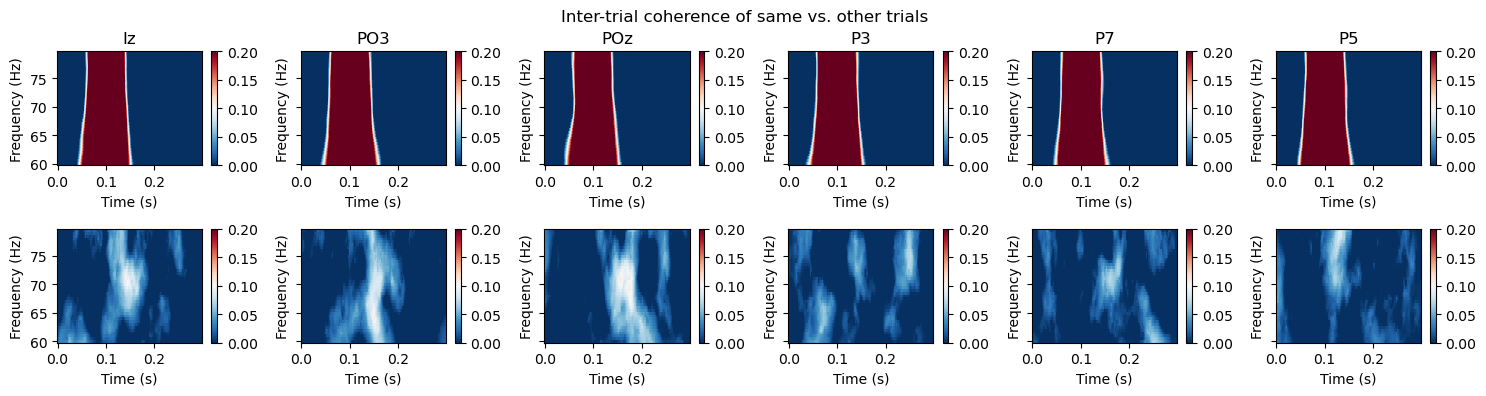

In [20]:
# Perform a time-frequency analysis of the cross-correlation
freqs = np.arange(60, 80, step = 0.5)
# Adapt the eeg info
epochs_noistag_cropped = epochs_noistag.copy().crop(tmin=tmin_eeg, tmax=tmax_eeg-(tmax_noise-tmin_noise)).pick(freqtag_electrodes).resample(sfreq)
# Do the time frequency analysis
itc_same = mne.time_frequency.tfr_array_morlet(same_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')
itc_other = mne.time_frequency.tfr_array_morlet(other_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')
# Store in MNE format
itc_same = mne.time_frequency.EpochsTFRArray(epochs_noistag_cropped.info, np.array([itc_same]), epochs_noistag_cropped.times, freqs)
itc_other = mne.time_frequency.EpochsTFRArray(epochs_noistag_cropped.info, np.array([itc_other]), epochs_noistag_cropped.times, freqs)


# Plot
fig, axes = plt.subplots(2, len(freqtag_electrodes), figsize=(15, 4), sharey = True) 
channels = epochs_noistag_cropped.info['ch_names']
for e, channel in enumerate(channels):
    itc_same.plot(
        [channel],
        baseline=(None,None),
        vlim=(0, .2),
        axes=axes[0,e],
        colorbar=True,
        show=False 
    )
    axes[0,e].set_title(channel) 
    itc_other.plot(
        [channel],
        baseline=(None,None),
        vlim=(0, .2),
        axes=axes[1,e],
        colorbar=True,
        show=False 
    )
plt.tight_layout()
plt.suptitle('Inter-trial coherence of same vs. other trials')
plt.show()

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.us

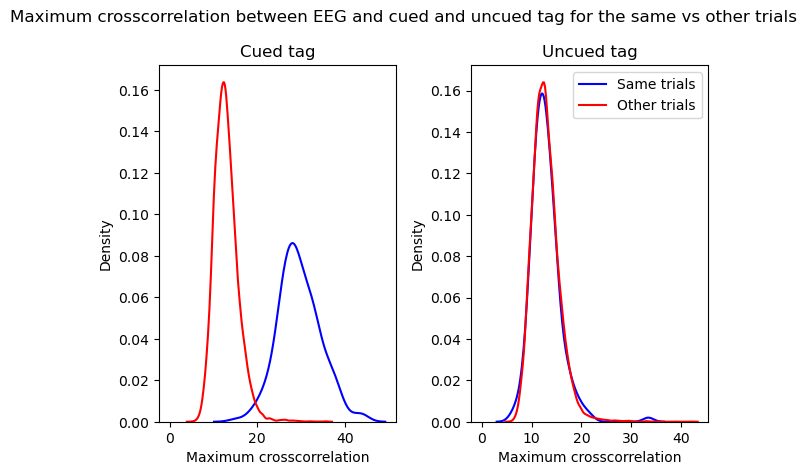

In [21]:
fig, ax = plt.subplots(1,2)
# Average cor over best frequency tagging electrodes, then extract the max for each trial
trialL = np.mean(trial_crosscorr_matL[0][:, :, :,:], axis=2).max(axis=-1)
trialR = np.mean(trial_crosscorr_matR[0][:, :, :,:], axis=2).max(axis=-1)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial_cued = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial_cued = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])

sns.kdeplot(same_trial_cued, color='blue', ax=ax[0])
sns.kdeplot(other_trial_cued, color='red', ax=ax[0])
ax[0].plot([0],[0], label='Same trials', color='blue')
ax[0].plot([0],[0], label='Other trials', color='red')
ax[0].set_xlabel('Maximum crosscorrelation')
ax[0].set_title('Cued tag')
plt.legend()

# Average cor over best frequency tagging electrodes, then extract the max for each trial
trialL = np.mean(trial_crosscorr_matL[1][:, :, :,:], axis=2).max(axis=-1)
trialR = np.mean(trial_crosscorr_matR[1][:, :, :,:], axis=2).max(axis=-1)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial_uncued = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial_uncued = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])

sns.kdeplot(same_trial_uncued, color='blue', ax=ax[1])
sns.kdeplot(other_trial_uncued, color='red', ax=ax[1])
ax[1].plot([0],[0], label='Same trials', color='blue')
ax[1].plot([0],[0], label='Other trials', color='red')
ax[1].set_title('Uncued tag')
ax[1].set_xlabel('Maximum crosscorrelation')
plt.suptitle('Maximum crosscorrelation between EEG and cued and uncued tag for the same vs other trials')
plt.legend()
plt.tight_layout()

### testing max cross-correlation by-trial in different time windows of the noise

In [22]:
def compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, side, electrodes, sfreq, tmin_eeg, tmax_eeg, tmin_noise, tmax_noise):
    side_idx = 0 if side == 'left' else \
        (1 if side == 'right' else ValueError("Invalid value for side"))

    trials = epochs_noistag[f'cued_side == {side_idx}'].metadata['trial_number']
    num_trials = len(trials)
    num_electrodes = len(electrodes)
    
    lag = int(np.round(lag * sfreq)) + 1

    # Initialize the cross-correlation matrix
    trial_crosscorr_matL = np.zeros((num_trials, num_trials-1, num_electrodes, lag))

    # Iterate over each trial to perform the cross-correlation
    for trial_idx, trial in enumerate(trials):
        trial_noise = copy.deepcopy(noise_stims_tr)
        # Repeat the noise sequences across all trials
        trial_noise = np.tile(trial_noise[trial], (len(noise_stims_tr), 1, 1))
        # Perform cross-correlation on all trials except the one with the tag
        cor_with_averaged_for_cuedL, _, _, _ = cross_cor_nois(
            epochs_fun=epochs_noistag[f'cued_side == {side_idx} & trial_number != {trial}'] ,
            noise=trial_noise,
            display_side_cued_tag=side,
            electrodes=electrodes,
            sampling_freq=sfreq,
            tmin_eeg=tmin_eeg,
            tmax_eeg=tmax_eeg,
            tmin_noise=tmin_noise,
            tmax_noise=tmax_noise,
            mean_tags=False
        )
        # Record the trial result
        trial_crosscorr_matL[trial_idx, :, :, :] = cor_with_averaged_for_cuedL[:, :, :]
    
    return trial_crosscorr_matL

In [23]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax

# Define lag, and the offset (after which delay to look for the crosscorrelation)
lag = .2
offset = .05

# Define period of noise to analyze
start = 0
duration = .4
step = .4
end = tmax_eeg-lag

# Create a list of tag segments
noise_periods = generate_noise_periods(start, end, duration, step)

# Matrix to store results
max_values_per_bin = np.zeros((len(noise_periods), len(epochs_noistag)))

# For each of the tag segments
for j, period in enumerate(noise_periods):
    tmin_noise, tmax_noise = period
    tmin_eeg_period, tmax_eeg_period = period
    tmin_eeg_period += offset
    tmax_eeg_period += offset
    tmax_eeg_period += lag
    
    # Get the crosscorrelation sliding over the all EEG epoch
    # With the average of the two tags when the cued side was right
    cor_with_cued_for_cuedR, _, idx_cuedR, times = \
        cross_cor_nois(epochs_fun = epochs_noistag, noise=noise_stims_tr, \
        display_side_cued_tag = 'right',  electrodes=freqtag_electrodes,\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg_period, tmax_eeg=tmax_eeg_period, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise, mean_tags = False)

    # get other trial crosscorrelation
    other_trialL = compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, 'right', freqtag_electrodes, sfreq, tmin_eeg_period, tmax_eeg_period, tmin_noise, tmax_noise)
    # take the max in time axis, average over the electrodes, turn into 1D to represent distribution of max crosscorr on trial without the displayed tag
    other_trialL = other_trialL.mean(axis=2).max(axis=-1).flatten()
    
    # With the average of the two tags when the cued side was left
    cor_with_cued_for_cuedL, _, idx_cuedL, times = \
        cross_cor_nois(epochs_noistag, noise_stims_tr, 'left', electrodes=freqtag_electrodes,\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg_period, tmax_eeg=tmax_eeg_period, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise, mean_tags = False)
    # get other trial crosscorrelation for right
    other_trialR = compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, 'right', freqtag_electrodes, sfreq, tmin_eeg_period, tmax_eeg_period, tmin_noise, tmax_noise)
    # take the max in time axis, average over the electrodes, turn into 1D to represent distribution of max crosscorr on trial without the displayed tag
    other_trialR = other_trialR.mean(axis=2).max(axis=-1).flatten()
    # Combine right and left cued side
    cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
    # Combine other trials for left and right cued side
    other = np.concatenate([other_trialR, other_trialL])

    # pick the max crosscorrelation, average over electrodes
    max_values_per_bin[j, :] = np.mean(cued, axis=1).max(axis=-1) - other.mean()

In [24]:
df_trial = pd.DataFrame(max_values_per_bin.T)
df_trial.columns = [f'{x[0]:.2f} - {x[1]:.2f}' for x in noise_periods]
df_trial = df_trial.melt()
# Turn the variable period into a coding matrix to estimate a linear model without intercept and 
# with one coefficient per period
one_hot_encoded = pd.get_dummies(df_trial['variable'])
design_matrix = pd.concat([df_trial['value'], one_hot_encoded], axis=1)
X = design_matrix.drop(columns=['value'])
y = design_matrix['value']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     282.6
Date:                Sat, 15 Jun 2024   Prob (F-statistic):          2.74e-160
Time:                        11:57:07   Log-Likelihood:                -2505.9
No. Observations:                 960   AIC:                             5022.
Df Residuals:                     955   BIC:                             5046.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
0.00 - 0.40     5.2811      0.238     22.174      

In [25]:
df_trial = pd.DataFrame(max_values_per_bin.T)
df_trial.columns = ['first','second','third','fourth','fifth']#[f'{x[0]:.1f}s' for i,x in enumerate(noise_periods)]
df_trial['trial'] = np.arange(len(df_trial))
df_trial_long = df_trial.melt(id_vars='trial', var_name='variable', value_name='value')

# Perform one-hot encoding on the noise periods
one_hot_encoded = pd.get_dummies(df_trial_long['variable'])

design_matrix = pd.concat([df_trial_long['value'],one_hot_encoded], axis=1)
trials =  df_trial_long['trial']

# Fit a LME
md = smf.mixedlm("value ~  second + third + fourth + fifth", design_matrix, groups=trials, re_formula="~ second + third + fourth + fifth")
result = md.fit()
print(result.summary())

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maxim

                     Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        value     
No. Observations:          960            Method:                    REML      
No. Groups:                192            Scale:                     4.5848    
Min. group size:           5              Log-Likelihood:            -2397.8133
Max. group size:           5              Converged:                 No        
Mean group size:           5.0                                                 
-------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                            5.281    0.222  23.828 0.000  4.847  5.715
second[T.True]                       3.837    0.331  11.581 0.000  3.188  4.486
third[T.True]                       -3.340    0.304 -10.985 0

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


# Adding 1% of Noise

In [26]:
epochs_noistag = epochs['tagging_type==1'].copy()
# bandpass (60-80Hz) EEG data 
epochs_noistag.filter(l_freq=60, h_freq = 80, verbose=True)
# Access noise tags
f = sio.loadmat(f'{data_path}{data_file}')
noise_stims = f['data']['noise_stims'][0][0] # block x trial x sequences (L or R tag) x timepoints
# Filter out practice trials
noise_stims = noise_stims[1:,:,:,:]

Setting up band-pass filter from 60 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 107 samples (0.223 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.4s


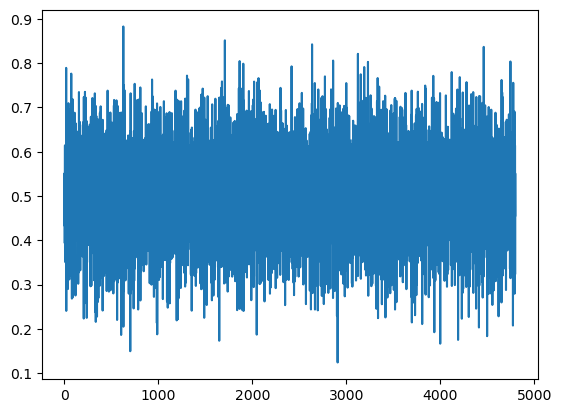

In [27]:
# First noise tag at block 15 trial 32
plt.plot((noise_stims[14,31,0,:].T+noise_stims[14,31,1,:].T)/2)
# NB : tag 1 was always displayed on the left and tag 2 on the right

In [28]:
# Collapse to trial indexes
original_shape = noise_stims.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
noise_stims_tr = np.reshape(noise_stims, new_shape)

In [29]:
noise_stims_tr.shape

(480, 2, 4800)

In [30]:
sfreq = 480
noise_stims_tr_fitlered = mne.filter.filter_data(noise_stims_tr, sfreq, None, 100)
tmin = epochs_noistag.tmin
tmax = epochs_noistag.tmax
#Up to when should the tag be present
tmax_noise = 1
# Inject to each EEG epoch its matching cued tag
buffer_arr = epochs_noistag.get_data()
# z-score EEG by electrode and trial
buffer_arr = (buffer_arr - np.mean(buffer_arr, axis=2, keepdims=True))/np.std(buffer_arr, axis=2, keepdims=True)
# Reverse the EEG to ensure no real crosscorrelation
buffer_arr = buffer_arr[:,:,::-1]

# After which sample from cue onset should the noise be in the data
for idx, trial in enumerate(epochs_noistag.metadata['trial_number']):
    # Delay is the delay between stimulation and translation in brain, here 100ms
    delay = int(.1*sfreq)
    # Offset is the moment where the noise is injected
    offset = int(np.random.normal(.1, .020)*sfreq)
    # Retrieve which tag was cued
    cued_side = int(epochs_noistag.metadata[epochs_noistag.metadata.trial_number == trial]['cued_side'])
    # Inject the tag displayed from cue onset to 800 ms after
    injected_tag = noise_stims_tr_fitlered[trial, cued_side, \
        :int(tmax_noise*sfreq)+1]
    # z-score tag
    injected_tag = (injected_tag - np.mean(injected_tag))/np.std(injected_tag)
    # Offset the moment of crosscorrelation but preserve phase
    injected_tag[:offset] = 0
    # Relative magnitude of the tag in the EEG
    injected_tag *= 0.02355
    # Add the tag from cue onset + time delay (offset)
    buffer_arr[idx,:,int(np.abs(epochs_noistag.tmin)*sfreq)+delay:int(np.abs(epochs_noistag.tmin)*sfreq+delay)+len(injected_tag)] += injected_tag
epochs_noistag._data = buffer_arr


Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 65 samples (0.135 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
/tmp/ipykernel_9728/2916496904.py:8: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  buffer_arr = epochs_noistag.get_data()
/tmp/ipykernel_9728/2916496904.py:21: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cued_side = int(epochs_noistag.metadata[epochs_noistag.metadata.trial_number == trial]['cued_side'])


## 1. Cross-correlation of the cued and uncued tags (tag duration from 0 to 1s)

The EEG from -1 to 2s is correlated with the tags from 0 to 1s (positive time lag up to 1000ms). 
Only trials without targets are included. 
The EEG is correlated with each tag.
The electrodes used are the best from the frequency tagging condition.

Text(0, 0.5, 'Cor EEG/tag')

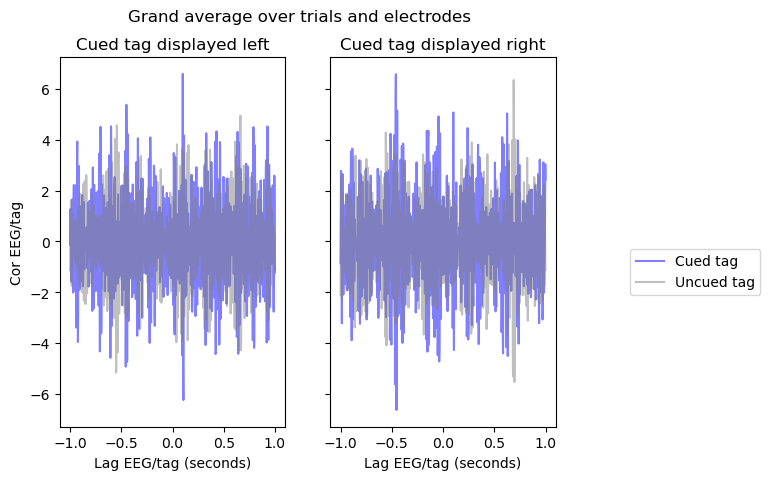

In [31]:
sfreq = 480 # EEG and tag 
tmin_eeg, tmax_eeg = -1, 2
tmin_noise, tmax_noise = 0, 1

cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = \
    cross_cor_nois(epochs_fun = epochs_noistag['target_binary == 0'], noise=noise_stims_tr, \
    display_side_cued_tag = 'right', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = \
    cross_cor_nois(epochs_noistag['target_binary == 0'], noise_stims_tr, 'left', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])


# Plot
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].plot(times,cor_with_cued_for_cuedL.mean(axis=(0,1)).T, color='blue', alpha=.5)
ax[0].plot(times,cor_with_uncued_for_cuedL.mean(axis=(0,1)).T, color='grey', alpha=.5)
ax[1].plot(times,cor_with_cued_for_cuedR.mean(axis=(0,1)).T, color='blue', label='Cued tag', alpha=.5)
ax[1].plot(times,cor_with_uncued_for_cuedR.mean(axis=(0,1)).T, color='grey', label='Uncued tag', alpha=.5)


ax[0].set_title('Cued tag displayed left');
ax[1].set_title('Cued tag displayed right');
plt.suptitle('Grand average over trials and electrodes');

ax[1].legend(bbox_to_anchor = (1.3,0.5))
ax[0].set_xlabel('Lag EEG/tag (seconds)')
ax[1].set_xlabel('Lag EEG/tag (seconds)')
ax[0].set_ylabel('Cor EEG/tag')

In [32]:
# # Export for group visualization
# # First average over trials, normalize the crosscorrelation, then average over electrodes
# cor_with_cued_norm = normalize_per_trial(cor_with_cued.mean(axis=0)).mean(axis=0)
# cor_with_uncued_norm = normalize_per_trial(cor_with_uncued.mean(axis=0)).mean(axis=0)

# crosscorr_time = pd.DataFrame({'Time':times,
#               'Cued':cor_with_cued_norm,
#               'Uncued':cor_with_uncued_norm})
# crosscorr_time = crosscorr_time.melt(id_vars='Time')
# crosscorr_time['Cueing'] = crosscorr_time['variable']
# crosscorr_time = crosscorr_time.drop('variable', axis=1)
# crosscorr_time.to_csv('files/A2_crosscorr_time.csv')


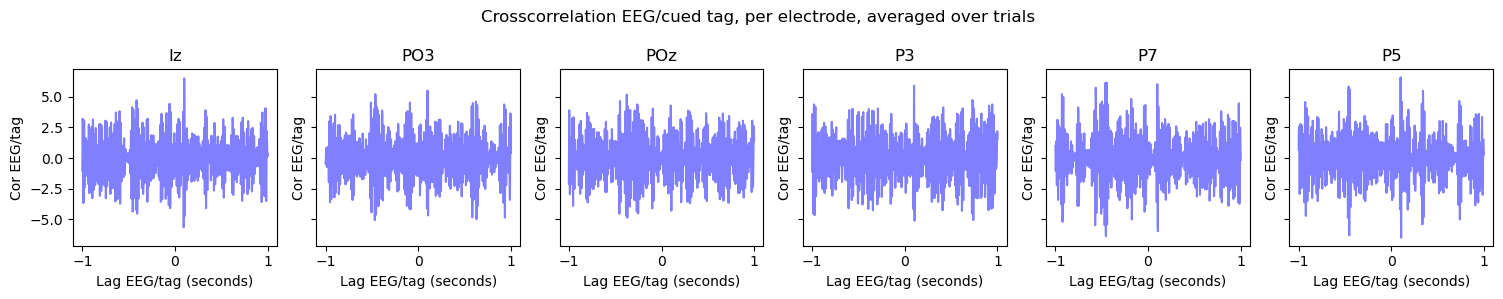

In [33]:
fig, ax = plt.subplots(1,len(freqtag_electrodes), figsize=(15, 3), sharey=True, sharex=True)
for e, elec in enumerate(freqtag_electrodes):
    ax[e].plot(times, cor_with_cued[:, e, :].mean(axis=0).T, color='blue', alpha=0.5)
    ax[e].set_title(elec)
    ax[e].set_xlabel('Lag EEG/tag (seconds)')
    ax[e].set_ylabel('Cor EEG/tag')
plt.suptitle('Crosscorrelation EEG/cued tag, per electrode, averaged over trials')
plt.tight_layout()
plt.show()


Sampling frequency of the instance is already 480.0, returning unmodified.


/tmp/ipykernel_9728/1178954655.py:6: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  tfr = mne.time_frequency.tfr_array_morlet(cor_with_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10)


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


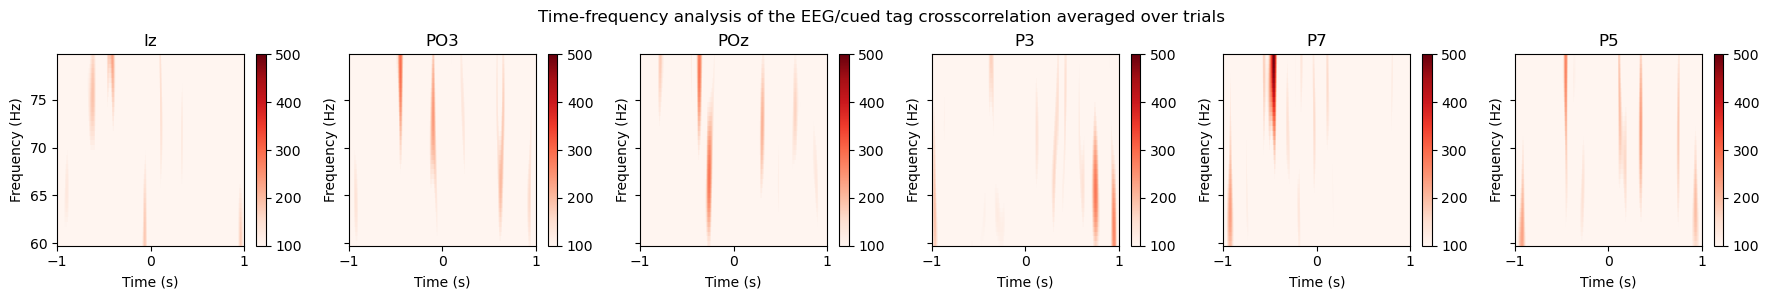

In [34]:
# Perform a time-frequency analysis of the cross-correlation
freqs = np.arange(60, 80, step = 0.5)
# Adapt the eeg info
epochs_noistag_cropped = epochs_noistag.copy().pick(freqtag_electrodes).crop(tmin=tmin_eeg, tmax=tmax_eeg-(tmax_noise-tmin_noise)).resample(sfreq)
# Do the time frequency analysis
tfr = mne.time_frequency.tfr_array_morlet(cor_with_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10)
# Store in MNE format
tfr = mne.time_frequency.EpochsTFRArray(epochs_noistag_cropped.info, np.array([tfr[:,:,:,:].mean(axis=0)]), epochs_noistag_cropped.times, freqs)

# Plot
fig, axes = plt.subplots(1, len(freqtag_electrodes), figsize=(18, 3), sharey = True) 
axes = axes.flatten() 
channels = epochs_noistag_cropped.info['ch_names']
for e, (channel, ax) in enumerate(zip(channels, axes)):
    tfr.plot(
        [channel],
        baseline=(None,0),
        vlim=(100, 500),
        axes=ax,
        colorbar=True,
        show=False 
    )
    ax.set_title(channel) 
plt.tight_layout()
plt.suptitle('Time-frequency analysis of the EEG/cued tag crosscorrelation averaged over trials')
plt.show()



### 1.1 Comparing max cross-correlation pre vs post cue

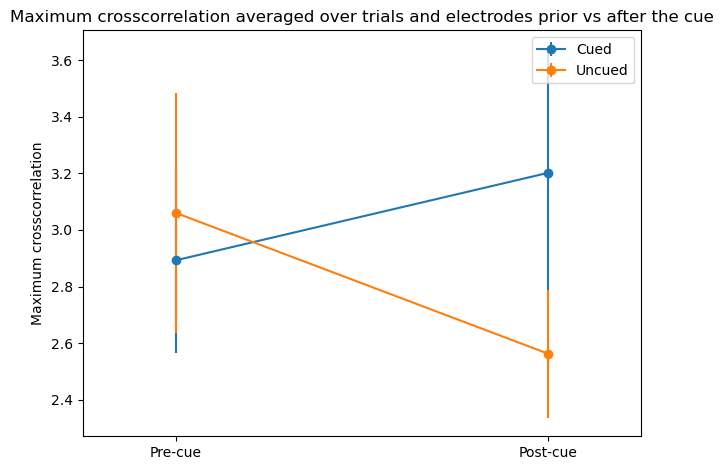

In [35]:
cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])


max_precue_cued = normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,:int(times.max()*sfreq)].max(axis=-1)
max_postcue_cued = normalize_per_trial(np.mean(cor_with_cued, axis=0))[:,-int(times.max()*sfreq):].max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_cued), np.mean(max_postcue_cued)],
                yerr=[np.std(max_precue_cued), np.std(max_postcue_cued)], fmt='o-', label='Cued')
max_precue_uncued = normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,:int(times.max()*sfreq)].max(axis=-1)
max_postcue_uncued = normalize_per_trial(np.mean(cor_with_uncued, axis=0))[:,-int(times.max()*sfreq):].max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_uncued), np.mean(max_postcue_uncued)],
                yerr=[np.std(max_precue_uncued), np.std(max_postcue_uncued)], fmt='o-', label='Uncued')
                        
plt.xticks([0,1],['Pre-cue', 'Post-cue'])
plt.title('Maximum crosscorrelation averaged over trials and electrodes prior vs after the cue')
plt.legend()
plt.ylabel('Maximum crosscorrelation')
plt.xlim(-.25, 1.25)
plt.tight_layout()

In [36]:
# # Export for group analysis
# crosscor_prepost = {}
# crosscor_prepost['cued_pre'] = normalize_per_trial(cor_with_cued.mean(axis=0))[:,:cor_with_cued.shape[-1]//2+1].max(axis=-1)
# crosscor_prepost['cued_post'] = normalize_per_trial(cor_with_cued.mean(axis=0))[:,cor_with_cued.shape[-1]//2:].max(axis=-1)
# crosscor_prepost['uncued_pre'] = normalize_per_trial(cor_with_uncued.mean(axis=0))[:,:cor_with_uncued.shape[-1]//2+1].max(axis=-1)
# crosscor_prepost['uncued_post'] = normalize_per_trial(cor_with_uncued.mean(axis=0))[:,cor_with_uncued.shape[-1]//2:].max(axis=-1)
# crosscor_prepost['uncued_post'] 
# crosscor_prepost_df = pd.DataFrame(crosscor_prepost)
# crosscor_prepost_df = crosscor_prepost_df.melt()
# crosscor_prepost_df[['cued', 'prepost']] = crosscor_prepost_df['variable'].str.split('_', expand=True)
# crosscor_prepost_df = crosscor_prepost_df.drop('variable', axis=1)
# crosscor_prepost_df.to_csv('files/A2_crosscor_prepost.csv',index=False)

### 3.2 Timing of the crosscorrelation with each of the tags (cueing effect)

In [37]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
lag = .1

# Define period of noise to analyze
start = 0
duration = .4
step = .1
end = tmax_eeg-lag
# Create a list of tag segments of duration 400ms with a step of 100ms
noise_periods = generate_noise_periods(start, end, duration, step)[::-1]

# EEG segments studied
n_bins = 20
time_bins = np.linspace(start, tmax_eeg-duration, n_bins+1)*sfreq

max_values_per_bin_cued = np.zeros((len(noise_periods), n_bins))
max_values_per_bin_uncued = np.zeros((len(noise_periods), n_bins))

for j, period in enumerate(noise_periods):
    tmin_noise, tmax_noise = period
    
    cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = \
        cross_cor_nois(epochs_fun = epochs_noistag, noise=noise_stims_tr, \
        display_side_cued_tag = 'right',\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = \
        cross_cor_nois(epochs_noistag, noise_stims_tr, 'left', \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
    uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])

    for i in range(n_bins):
        start_idx = int(time_bins[i])
        end_idx = int(time_bins[i + 1])
        max_values_per_bin_cued[j, i] = np.mean(normalize_per_trial(cued.mean(axis=0)), axis=0)[start_idx:end_idx].max()
        max_values_per_bin_uncued[j, i] = np.mean(normalize_per_trial(uncued.mean(axis=0)), axis=0)[start_idx:end_idx].max()
    


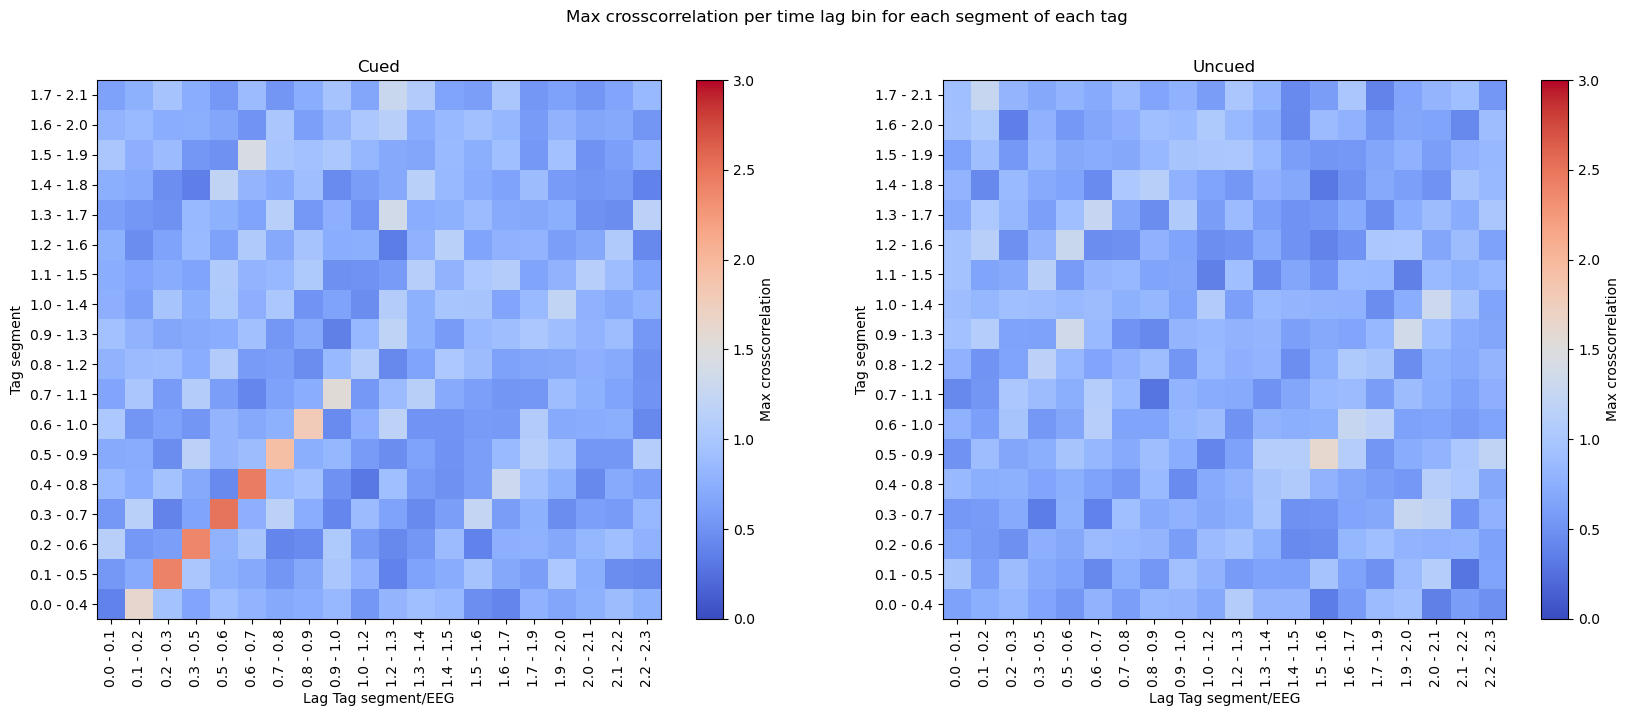

In [38]:
fig, ax = plt.subplots(1,2, figsize=(20,7), sharey=False)

cax = ax[0].imshow(max_values_per_bin_cued, aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=3)
cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation')
cax = ax[1].imshow(max_values_per_bin_uncued, aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=3)
cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation')

ax[0].set_xlabel('Lag Tag segment/EEG')
ax[0].set_ylabel('Tag segment')
ax[1].set_xlabel('Lag Tag segment/EEG')
ax[1].set_ylabel('Tag segment')
plt.suptitle('Max crosscorrelation per time lag bin for each segment of each tag')

bin_times = np.linspace(start, end, n_bins)
diff_bins = np.diff(bin_times)[0]

for axi in ax:
    axi.set_xticks(np.arange(n_bins))
    axi.set_xticklabels([f'{bt:.1f} - {bt+diff_bins:.1f}' for bt in bin_times], rotation=90)
    axi.set_yticks(np.arange(len(noise_periods)))
    axi.set_yticklabels([f'{i[0]:.1f} - {i[1]:.1f}' for i in noise_periods])


ax[0].set_title('Cued')
ax[1].set_title('Uncued')
plt.show()

### 1.2 Comparing max cross-correlation on displayed trial vs others

In [39]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
tmin_noise, tmax_noise = 0, 2

# First for left cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 0'].selection]
# (cued, uncued), trial, elec, time
trial_crosscorr_matL = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'left', electrodes=freqtag_electrodes, \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matL[0, trial_idx, :, :, :] = cor_with_cued_for_cuedL[:, :, :]
    trial_crosscorr_matL[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedL[:, :, :]

# For right cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 1'].selection]
trial_crosscorr_matR = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[ trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'right', electrodes=freqtag_electrodes,  \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matR[0, trial_idx, :, :, :] = cor_with_cued_for_cuedR[:, :, :]
    trial_crosscorr_matR[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedR[:, :, :]

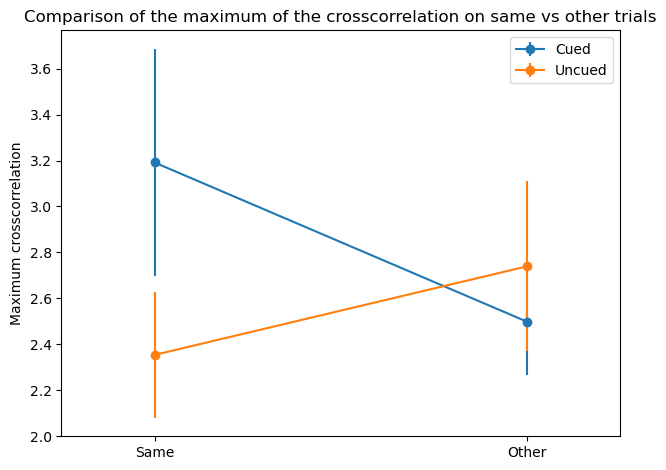

In [40]:
same_cued, same_uncued = [], []
other_cued, other_uncued = [], []

num_trials = trial_crosscorr_matL[0].shape[0]
for trial in range(num_trials):
    # Pick the same trial by taking the diagonal
    same_cued.append(trial_crosscorr_matL[0][trial, trial])
    same_uncued.append(trial_crosscorr_matL[1][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued.append(trial_crosscorr_matL[0][trial, sampled_index])
    other_uncued.append(trial_crosscorr_matL[1][trial, sampled_index])
    
num_trials = trial_crosscorr_matR[0].shape[0]
for trial in range(num_trials):
    same_cued.append(trial_crosscorr_matR[0][trial, trial])
    same_uncued.append(trial_crosscorr_matR[1][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued.append(trial_crosscorr_matR[0][trial, sampled_index])
    other_uncued.append(trial_crosscorr_matR[1][trial, sampled_index])

plt.errorbar(x=[0,1], y=[normalize_per_trial(np.array(same_cued).mean(axis=(0))).max(axis=-1).mean(), normalize_per_trial(np.array(other_cued).mean(axis=(0))).max(axis=-1).mean()],
                yerr=[normalize_per_trial(np.array(same_cued).mean(axis=(0))).max(axis=-1).std(), normalize_per_trial(np.array(other_cued).mean(axis=(0))).max(axis=-1).std()], fmt='o-', label='Cued')
plt.errorbar(x=[0,1], y=[normalize_per_trial(np.array(same_uncued).mean(axis=(0))).max(axis=-1).mean(), normalize_per_trial(np.array(other_uncued).mean(axis=(0))).max(axis=-1).mean()],
                yerr=[normalize_per_trial(np.array(same_uncued).mean(axis=(0))).max(axis=-1).std(), normalize_per_trial(np.array(other_uncued).mean(axis=(0))).max(axis=-1).std()], fmt='o-', label='Uncued')
plt.xticks([0,1],['Same', 'Other'])
plt.title('Comparison of the maximum of the crosscorrelation on same vs other trials')
plt.legend()
plt.ylabel('Maximum crosscorrelation')
plt.xlim(-.25, 1.25)
plt.tight_layout()

Sampling frequency of the instance is already 480.0, returning unmodified.


/tmp/ipykernel_9728/3164116203.py:6: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  itc_same = mne.time_frequency.tfr_array_morlet(same_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')
/tmp/ipykernel_9728/3164116203.py:7: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  itc_other = mne.time_frequency.tfr_array_morlet(other_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


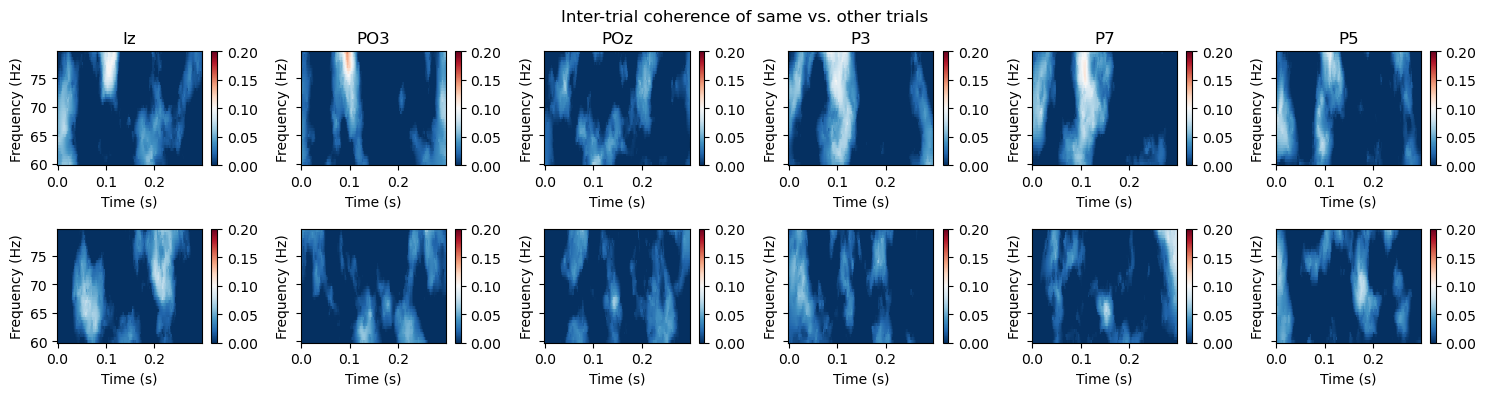

In [41]:
# Perform a time-frequency analysis of the cross-correlation
freqs = np.arange(60, 80, step = 0.5)
# Adapt the eeg info
epochs_noistag_cropped = epochs_noistag.copy().crop(tmin=tmin_eeg, tmax=tmax_eeg-(tmax_noise-tmin_noise)).pick(freqtag_electrodes).resample(sfreq)
# Do the time frequency analysis
itc_same = mne.time_frequency.tfr_array_morlet(same_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')
itc_other = mne.time_frequency.tfr_array_morlet(other_cued, epochs_noistag_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')
# Store in MNE format
itc_same = mne.time_frequency.EpochsTFRArray(epochs_noistag_cropped.info, np.array([itc_same]), epochs_noistag_cropped.times, freqs)
itc_other = mne.time_frequency.EpochsTFRArray(epochs_noistag_cropped.info, np.array([itc_other]), epochs_noistag_cropped.times, freqs)


# Plot
fig, axes = plt.subplots(2, len(freqtag_electrodes), figsize=(15, 4), sharey = True) 
channels = epochs_noistag_cropped.info['ch_names']
for e, channel in enumerate(channels):
    itc_same.plot(
        [channel],
        baseline=(None,None),
        vlim=(0, .2),
        axes=axes[0,e],
        colorbar=True,
        show=False 
    )
    axes[0,e].set_title(channel) 
    itc_other.plot(
        [channel],
        baseline=(None,None),
        vlim=(0, .2),
        axes=axes[1,e],
        colorbar=True,
        show=False 
    )
plt.tight_layout()
plt.suptitle('Inter-trial coherence of same vs. other trials')
plt.show()

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.us

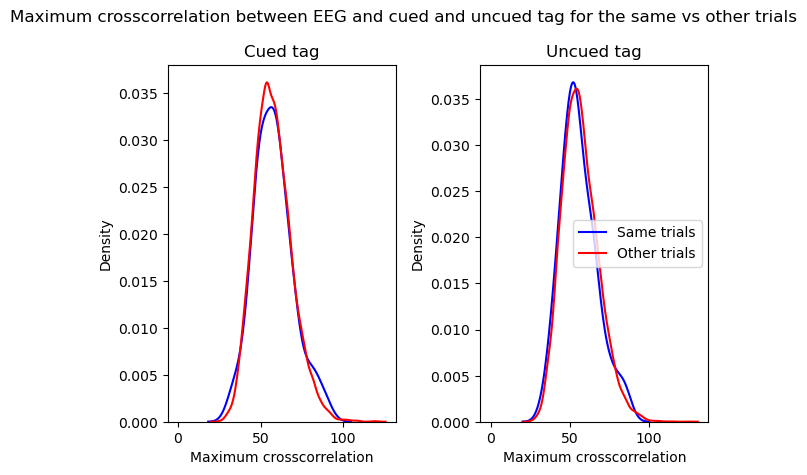

In [42]:
fig, ax = plt.subplots(1,2)
# Average cor over best frequency tagging electrodes, then extract the max for each trial
trialL = np.mean(trial_crosscorr_matL[0][:, :, :,:], axis=2).max(axis=-1)
trialR = np.mean(trial_crosscorr_matR[0][:, :, :,:], axis=2).max(axis=-1)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial_cued = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial_cued = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])

sns.kdeplot(same_trial_cued, color='blue', ax=ax[0])
sns.kdeplot(other_trial_cued, color='red', ax=ax[0])
ax[0].plot([0],[0], label='Same trials', color='blue')
ax[0].plot([0],[0], label='Other trials', color='red')
ax[0].set_xlabel('Maximum crosscorrelation')
ax[0].set_title('Cued tag')
plt.legend()

# Average cor over best frequency tagging electrodes, then extract the max for each trial
trialL = np.mean(trial_crosscorr_matL[1][:, :, :,:], axis=2).max(axis=-1)
trialR = np.mean(trial_crosscorr_matR[1][:, :, :,:], axis=2).max(axis=-1)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial_uncued = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial_uncued = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])

sns.kdeplot(same_trial_uncued, color='blue', ax=ax[1])
sns.kdeplot(other_trial_uncued, color='red', ax=ax[1])
ax[1].plot([0],[0], label='Same trials', color='blue')
ax[1].plot([0],[0], label='Other trials', color='red')
ax[1].set_title('Uncued tag')
ax[1].set_xlabel('Maximum crosscorrelation')
plt.suptitle('Maximum crosscorrelation between EEG and cued and uncued tag for the same vs other trials')
plt.legend()
plt.tight_layout()

### testing max cross-correlation by-trial in different time windows of the noise

In [43]:
def compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, side, electrodes, sfreq, tmin_eeg, tmax_eeg, tmin_noise, tmax_noise):
    side_idx = 0 if side == 'left' else \
        (1 if side == 'right' else ValueError("Invalid value for side"))

    trials = epochs_noistag[f'cued_side == {side_idx}'].metadata['trial_number']
    num_trials = len(trials)
    num_electrodes = len(electrodes)
    
    lag = int(np.round(lag * sfreq)) + 1

    # Initialize the cross-correlation matrix
    trial_crosscorr_matL = np.zeros((num_trials, num_trials-1, num_electrodes, lag))

    # Iterate over each trial to perform the cross-correlation
    for trial_idx, trial in enumerate(trials):
        trial_noise = copy.deepcopy(noise_stims_tr)
        # Repeat the noise sequences across all trials
        trial_noise = np.tile(trial_noise[trial], (len(noise_stims_tr), 1, 1))
        # Perform cross-correlation on all trials except the one with the tag
        cor_with_averaged_for_cuedL, _, _, _ = cross_cor_nois(
            epochs_fun=epochs_noistag[f'cued_side == {side_idx} & trial_number != {trial}'] ,
            noise=trial_noise,
            display_side_cued_tag=side,
            electrodes=electrodes,
            sampling_freq=sfreq,
            tmin_eeg=tmin_eeg,
            tmax_eeg=tmax_eeg,
            tmin_noise=tmin_noise,
            tmax_noise=tmax_noise,
            mean_tags=False
        )
        # Record the trial result
        trial_crosscorr_matL[trial_idx, :, :, :] = cor_with_averaged_for_cuedL[:, :, :]
    
    return trial_crosscorr_matL

In [44]:
tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax

# Define lag, and the offset (after which delay to look for the crosscorrelation)
lag = .2
offset = .05

# Define period of noise to analyze
start = 0
duration = .4
step = .4
end = tmax_eeg-lag

# Create a list of tag segments
noise_periods = generate_noise_periods(start, end, duration, step)

# Matrix to store results
max_values_per_bin = np.zeros((len(noise_periods), len(epochs_noistag)))

# For each of the tag segments
for j, period in enumerate(noise_periods):
    tmin_noise, tmax_noise = period
    tmin_eeg_period, tmax_eeg_period = period
    tmin_eeg_period += offset
    tmax_eeg_period += offset
    tmax_eeg_period += lag
    
    # Get the crosscorrelation sliding over the all EEG epoch
    # With the average of the two tags when the cued side was right
    cor_with_cued_for_cuedR, _, idx_cuedR, times = \
        cross_cor_nois(epochs_fun = epochs_noistag, noise=noise_stims_tr, \
        display_side_cued_tag = 'right',  electrodes=freqtag_electrodes,\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg_period, tmax_eeg=tmax_eeg_period, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise, mean_tags = False)

    # get other trial crosscorrelation
    other_trialL = compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, 'right', freqtag_electrodes, sfreq, tmin_eeg_period, tmax_eeg_period, tmin_noise, tmax_noise)
    # take the max in time axis, average over the electrodes, turn into 1D to represent distribution of max crosscorr on trial without the displayed tag
    other_trialL = other_trialL.mean(axis=2).max(axis=-1).flatten()
    
    # With the average of the two tags when the cued side was left
    cor_with_cued_for_cuedL, _, idx_cuedL, times = \
        cross_cor_nois(epochs_noistag, noise_stims_tr, 'left', electrodes=freqtag_electrodes,\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg_period, tmax_eeg=tmax_eeg_period, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise, mean_tags = False)
    # get other trial crosscorrelation for right
    other_trialR = compute_other_trial_crosscorr(epochs_noistag, noise_stims_tr, lag, 'right', freqtag_electrodes, sfreq, tmin_eeg_period, tmax_eeg_period, tmin_noise, tmax_noise)
    # take the max in time axis, average over the electrodes, turn into 1D to represent distribution of max crosscorr on trial without the displayed tag
    other_trialR = other_trialR.mean(axis=2).max(axis=-1).flatten()
    # Combine right and left cued side
    cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
    # Combine other trials for left and right cued side
    other = np.concatenate([other_trialR, other_trialL])

    # pick the max crosscorrelation, average over electrodes
    max_values_per_bin[j, :] = np.mean(cued, axis=1).max(axis=-1) - other.mean()

In [45]:
df_trial = pd.DataFrame(max_values_per_bin.T)
df_trial.columns = [f'{x[0]:.2f} - {x[1]:.2f}' for x in noise_periods]
df_trial = df_trial.melt()
# Turn the variable period into a coding matrix to estimate a linear model without intercept and 
# with one coefficient per period
one_hot_encoded = pd.get_dummies(df_trial['variable'])
design_matrix = pd.concat([df_trial['value'], one_hot_encoded], axis=1)
X = design_matrix.drop(columns=['value'])
y = design_matrix['value']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.734
Date:                Sat, 15 Jun 2024   Prob (F-statistic):              0.140
Time:                        11:58:56   Log-Likelihood:                -3103.9
No. Observations:                 960   AIC:                             6218.
Df Residuals:                     955   BIC:                             6242.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
0.00 - 0.40    -1.1322      0.444     -2.550      

In [46]:
df_trial = pd.DataFrame(max_values_per_bin.T)
df_trial.columns = ['first','second','third','fourth','fifth']#[f'{x[0]:.1f}s' for i,x in enumerate(noise_periods)]
df_trial['trial'] = np.arange(len(df_trial))
df_trial_long = df_trial.melt(id_vars='trial', var_name='variable', value_name='value')

# Perform one-hot encoding on the noise periods
one_hot_encoded = pd.get_dummies(df_trial_long['variable'])

design_matrix = pd.concat([df_trial_long['value'],one_hot_encoded], axis=1)
trials =  df_trial_long['trial']

# Fit a LME
md = smf.mixedlm("value ~  second + third + fourth + fifth", design_matrix, groups=trials, re_formula="~ second + third + fourth + fifth")
result = md.fit()
print(result.summary())

                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        value     
No. Observations:         960            Method:                    REML      
No. Groups:               192            Scale:                     27.1821   
Min. group size:          5              Log-Likelihood:            -3093.5051
Max. group size:          5              Converged:                 Yes       
Mean group size:          5.0                                                 
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           -1.132    0.388 -2.921 0.003 -1.892 -0.372
second[T.True]                       1.367    0.601  2.275 0.023  0.189  2.544
third[T.True]                        1.151    0.586  1.964 0.050  0.002  